In [1]:
import pandas as pd
import numpy as np
import os
import sumolib
import random
from tqdm import tqdm
from datetime import datetime

# A. 이동류 매칭

In [2]:
# [이동류번호] 불러오기 (약 1분의 소요시간)
path_moves = '../../Data/tables/moves/'
csv_moves = os.listdir('../../Data/tables/moves/')
moves = [pd.read_csv(path_moves + csv_move, index_col=0) for csv_move in tqdm(csv_moves)]
match1 = pd.concat(moves).drop_duplicates().sort_values(by=['inter_no','phas_A','phas_B']).reset_index(drop=True)
match1.head(10)

100%|██████████| 17280/17280 [00:12<00:00, 1330.89it/s]


inter_no  phas_A  phas_B  move_A  move_B
0       175       1       1       8       4
1       175       2       2       7       3
2       175       3       3       6       1
3       175       3       4       6       2
4       175       4       4       5       2
5       176       1       1       8       4
6       176       2       2       8       3
7       176       3       3       5      18
8       177       1       1       8       4
9       177       2       2       7       3

In [3]:
# 계층화 (inter_no, phas_A, phas_B, move_A, move_B) -> ('inter_no', 'phase_no', 'ring_type', 'move_no')
matchA = match1[['inter_no', 'phas_A', 'move_A']].copy()
matchA.columns = ['inter_no', 'phase_no', 'move_no']
matchA['ring_type'] = 'A'
matchB = match1[['inter_no', 'phas_B', 'move_B']].copy()
matchB.columns = ['inter_no', 'phase_no', 'move_no']
matchB['ring_type'] = 'B'
match2 = pd.concat([matchA, matchB]).drop_duplicates()
match2 = match2[['inter_no', 'phase_no', 'ring_type', 'move_no']]
match2 = match2.sort_values(by=list(match2.columns))
match2.head(10)

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4

In [4]:
# [nema 이동류목록] 불러오기 및 병합
nema = pd.read_csv('../../Data/tables/nema.csv', encoding='cp949')
match3 = pd.merge(match2, nema, how='left', on='move_no').drop_duplicates()
match3

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
..       ...       ...       ...      ...     ...     ...
59       210         4         B        3       남       서
60       211         1         A        6       동       서
61       211         1         B        2       서       동
62       211         2         A       17     NaN     NaN
63       211         2         B       18     NaN     NaN

[64 rows x 6 columns]

In [5]:
# [방위각정보] 불러오기, 계층화, 병합
# 불러오기
dtype_dict = {f'angle_{alph}{j}':'str' for alph in ['A', 'B'] for j in range(1,9)}
angle_original = pd.read_csv('../../Data/tables/angle.csv', index_col=0, dtype = dtype_dict)
# 계층화
angle = []
for i, row in angle_original.iterrows():
    angle_codes = row[[f'angle_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
    new = pd.DataFrame({'inter_no':[row.inter_no] * 16, 'phase_no':list(range(1, 9))*2, 'ring_type':['A'] * 8 + ['B'] * 8, 'angle_code':angle_codes.to_list()})
    angle.append(new)
angle = pd.concat(angle)
angle = angle.dropna().reset_index(drop=True)
# 병합
six_chars = angle.angle_code.apply(lambda x:len(x)==6)
angle.loc[six_chars,'inc_angle'] = angle.angle_code.apply(lambda x:x[:3])
angle.loc[six_chars,'out_angle'] = angle.angle_code.apply(lambda x:x[3:])
angle = angle.drop('angle_code', axis=1)
match4 = pd.merge(match3, angle, how='left', left_on=['inter_no', 'phase_no', 'ring_type'],
                 right_on=['inter_no', 'phase_no', 'ring_type']).drop_duplicates()
match4

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       003       176
2        175         2         A        7       북       동       001       095
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       090       270
..       ...       ...       ...      ...     ...     ...       ...       ...
59       210         4         B        3       남       서       180       270
60       211         1         A        6       동       서       090       270
61       211         1         B        2       서       동       270       090
62       211         2         A       17     NaN     NaN       NaN       NaN
63       211         2         B       18     NaN     NaN       NaN       NaN

[64 rows x 8 columns]

In [6]:
# [네트워크], [교차로-노드 매칭], [교차로정보] 불러오기 
net = sumolib.net.readNet('../../Data/networks/SN_sample.net.xml')
inter_node = pd.read_csv('../../Data/tables/inter_node.csv', index_col=0)
inter_info = pd.read_csv('../../Data/tables/inter_info.csv', index_col=0)

inter_node1 = inter_node[inter_node.inter_type == 'parent'].drop('inter_type', axis=1)
inter_info1 = inter_info[['inter_no', 'inter_lat', 'inter_lon']]
inter = pd.merge(inter_node1, inter_info1, how='left', left_on=['inter_no'],
                 right_on=['inter_no']).drop_duplicates()

inter2node = dict(zip(inter['inter_no'], inter['node_id']))

match5 = match4.copy()
# 진입진출ID 매칭
for index, row in match5.iterrows():
    node_id = inter2node[row.inter_no]
    node = net.getNode(node_id)
    # 교차로의 모든 (from / to) edges
    inc_edges = [edge for edge in node.getIncoming() if edge.getFunction() == ''] # incoming edges
    out_edges = [edge for edge in node.getOutgoing() if edge.getFunction() == ''] # outgoing edges
    # 교차로의 모든 (from / to) directions
    inc_dirs = []
    for inc_edge in inc_edges:
        start = inc_edge.getShape()[-2]
        end = inc_edge.getShape()[-1]
        inc_dir = np.array(end) - np.array(start)
        inc_dir = inc_dir / (inc_dir ** 2).sum() ** 0.5
        inc_dirs.append(inc_dir)
    out_dirs = []
    for out_edge in out_edges:
        start = out_edge.getShape()[0]
        end = out_edge.getShape()[1]
        out_dir = np.array(end) - np.array(start)
        out_dir = out_dir / (out_dir ** 2).sum() ** 0.5
        out_dirs.append(out_dir)
    # 진입각, 진출각 불러오기
    if not pd.isna(row.inc_angle):
        inc_angle = int(row.inc_angle)
        out_angle = int(row.out_angle)
        # 방위각을 일반각으로 가공, 라디안 변환, 단위벡터로 변환
        inc_angle = (-90 - inc_angle) % 360
        inc_angle = inc_angle * np.pi / 180.
        inc_dir_true = np.array([np.cos(inc_angle), np.sin(inc_angle)])
        out_angle = (90 - out_angle) % 360
        out_angle = out_angle * np.pi / 180.
        out_dir_true = np.array([np.cos(out_angle), np.sin(out_angle)])
        # 매칭 엣지 반환
        inc_index = np.array([np.dot(inc_dir, inc_dir_true) for inc_dir in inc_dirs]).argmax()
        out_index = np.array([np.dot(out_dir, out_dir_true) for out_dir in out_dirs]).argmax()
        inc_edge_id = inc_edges[inc_index].getID()
        out_edge_id   = out_edges[out_index].getID()
        match5.at[index, 'inc_edge'] = inc_edge_id
        match5.at[index, 'out_edge'] = out_edge_id
match5['node_id'] = match5['inter_no'].map(inter2node)
# match5 = match5[['inter_no', 'node_id', 'move_no', 'inc_edge', 'out_edge']]
match5 = match5.sort_values(by=['inter_no', 'move_no']).reset_index(drop=True)

In [7]:
# 이동류 매칭
# 각 교차로에 대하여, 가능한 모든 이동류(1~18, 21)에 대한 진입·진출엣지ID를 지정한다.
# 모든 이동류에 대해 지정하므로, 시차제시 이전과 다른 이동류가 등장하더라도 항상 진입·진출 엣지 ID를 지정할 수 있다.
match6 = match5.copy().dropna()
match6 = match6[['inter_no', 'move_no', 'inc_dir', 'out_dir', 'inc_edge', 'out_edge', 'node_id']]
# (1) 가능한 (진입방향, 진출방향) 목록
flows = nema.dropna().apply(lambda row: (row['inc_dir'], row['out_dir']), axis=1).tolist()
# (2) 각 교차로별 방향 목록 : pdires
pdires = {}
for inter_no in match6.inter_no.unique():
    dires = match6[match6.inter_no == inter_no][['inc_dir','out_dir']].values.flatten()
    dires = {dire for dire in dires if type(dire)==str}
    pdires[inter_no] = dires
# (3) 각 (교차로, 진입방향) 별 진입id 목록 : inc2id
inc2id = {}
for inter_no in match6.inter_no.unique():
    for inc_dir in pdires[inter_no]:
        df = match6[(match6.inter_no==inter_no) & (match6.inc_dir==inc_dir)]
        inc2id[(inter_no, inc_dir)] = df.inc_edge.iloc[0]
# (4) 각 (교차로, 진출방향) 별 진출id 목록 : out2id
out2id = {}
for inter_no in match6.inter_no.unique():
    for out_dir in pdires[inter_no]:
        df = match6[(match6.inter_no==inter_no) & (match6.out_dir==out_dir)]
        out2id[(inter_no, out_dir)] = df.out_edge.iloc[0]
# (5) 각 교차로별 가능한 (진입방향, 진출방향) 목록 : pflows
pflow = {}
for inter_no in match6.inter_no.unique():
    pflow[inter_no] = [flow for flow in flows if set(flow).issubset(pdires[inter_no])]
# (6) 가능한 이동류에 대하여 진입id, 진출id 배정 : matching
inter2node = dict(zip(match6['inter_no'], match6['node_id']))
dires_right = ['북', '서', '남', '동', '북']
matching = []
for inter_no in match6.inter_no.unique():
    node_id = inter2node[inter_no]
    # 좌회전과 직진(1 ~ 16)
    for (inc_dir, out_dir) in pflow[inter_no]:
        move_no = nema[(nema.inc_dir==inc_dir) & (nema.out_dir==out_dir)].move_no.iloc[0]
        inc_edge = inc2id[(inter_no, inc_dir)]
        out_edge = out2id[(inter_no, out_dir)]
        new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[move_no],
                                'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
        matching.append(new_row)
    # 보행신호(17), 전적색(18)
    new_row = pd.DataFrame({'inter_no':[inter_no] * 2, 'move_no':[17, 18],
                            'inc_dir':[None]*2, 'out_dir':[None]*2,
                            'inc_edge':[None]*2, 'out_edge':[None]*2, 'node_id':[node_id]*2})
    matching.append(new_row)
    # 신호우회전(21)
    for d in range(len(dires_right)-1):
        inc_dir = dires_right[d]
        out_dir = dires_right[d+1]
        if {inc_dir, out_dir}.issubset(pdires[inter_no]):
            inc_edge = inc2id[(inter_no, inc_dir)]
            out_edge = out2id[(inter_no, out_dir)]
            new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[21],
                                    'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                    'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
            matching.append(new_row)
matching = pd.concat(matching)
matching = matching.sort_values(by=['inter_no', 'move_no']).reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(matching)

inter_no  move_no inc_dir out_dir          inc_edge          out_edge  \
0        175        1       동       남      571545870_02      571542797_02   
1        175        2       서       동      571510153_02      571545870_01   
2        175        3       남       서     -571542797_02      571510153_01   
3        175        4       북       남     -571500487_01      571542797_02   
4        175        5       서       북      571510153_02      571500487_01   
5        175        6       동       서      571545870_02      571510153_01   
6        175        7       북       동     -571500487_01      571545870_01   
7        175        8       남       북     -571542797_02      571500487_01   
8        175       17    None    None              None              None   
9        175       18    None    None              None              None   
10       175       21       북       서     -571500487_01      571510153_01   
11       175       21       서       남      571510153_02      571542797_02   
12       175       21       남       동     -571542797_02      571545870_01   
13       175       21       동       북      571545870_02      571500487_01   
14       176        3       남       서     -571542810_01      571543469_01   
15       176        4       북       남   571542797_02.99      571542810_01   
16       176        5       서       북      571543469_02  -571542797_02.99   
17       176        8       남       북     -571542810_01  -571542797_02.99   
18       176       17    None    None              None              None   
19       176       18    None    None              None              None   
20       176       21       북       서   571542797_02.99      571543469_01   
21       176       21       서       남      571543469_02      571542810_01   
22       177        1       동       남      571542107_02      571542809_01   
23       177        2       서       동     -571542809_01      571542107_01   
24       177        3       남       서     -571542809_01      571542809_01   
25       177        4       북       남      571542811_02      571542809_01   
26       177        5       서       북     -571542809_01      571542811_01   
27       177        6       동       서      571542107_02      571542809_01   
28       177        7       북       동      571542811_02      571542107_01   
29       177        8       남       북     -571542809_01      571542811_01   
30       177       17    None    None              None              None   
31       177       18    None    None              None              None   
32       177       21       북       서      571542811_02      571542809_01   
33       177       21       서       남     -571542809_01      571542809_01   
34       177       21       남       동     -571542809_01      571542107_01   
35       177       21       동       북      571542107_02      571542811_01   
36       178        1       동       남     -571500475_01      571540304_01   
37       178        2       서       동   571540303_02.21      571500475_01   
38       178        3       남       서      571540304_02      571540303_01   
39       178        4       북       남      571556450_02      571540304_01   
40       178        5       서       북   571540303_02.21      571556450_01   
41       178        6       동       서     -571500475_01      571540303_01   
42       178        7       북       동      571556450_02      571500475_01   
43       178        8       남       북      571540304_02      571556450_01   
44       178       17    None    None              None              None   
45       178       18    None    None              None              None   
46       178       21       북       서      571556450_02      571540303_01   
47       178       21       서       남   571540303_02.21      571540304_01   
48       178       21       남       동      571540304_02      571500475_01   
49       178       21       동       북     -571500475_01      571556450_01   
50       201        1       동       남      571500617_02      571500569_01   


# B. 5초 간격으로 이동류번호 수집

In [8]:
# 5초 단위로 이동류번호 저장 및 신호이력에서 유닉스시각 가져와서 표시, 한시간동안의 데이터만 보관
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fsecs = range(midnight, next_day, 5) # fsecs : unix time by Five SECondS
time2move = dict(zip(fsecs,moves)) # move : 어느 순간의 이동류정보
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)

time2movement = {} # movement : 어느 순간의, 그 순간으로부터 한시간 동안의 (교차로번호 + 현시별이동류번호 + 시작시간)
# - 아래 절차를 5초마다 반복
for fsec in tqdm(fsecs): # fsec : unix time by Five SECond
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    move = time2move[fsec]
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < fsec].groupby('inter_no')] # 교차로별로 유닉스시간이 최대인 행들
    if not recent_histories:
        rhistory = pd.DataFrame({'inter_no':[], 'end_unix':[]}) # recent history
    else:
        rhistory = pd.concat(recent_histories)
    recent_unix = rhistory[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    move = move.drop_duplicates()
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame): # movement가 존재할 경우 그걸 그대로 씀.
            pass
        else: 
            movement = pd.DataFrame()
    except NameError: # movement가 존재하지 않는 경우 생성
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > fsec - 3600]
    start_unix_min = movement.start_unix.min()
    start_unix_max = movement.start_unix.max()
    movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)

    time2movement[fsec] = movement
    movement.to_csv(f'../../Data/tables/movements/movements_{fsec}.csv')

# 각 movement들의 길이 시각화
import matplotlib.pyplot as plt
plt.plot(fsecs, [len(time2movement[fsec]) for fsec in fsecs])
plt.close()

  0%|          | 0/17280 [00:00<?, ?it/s]

100%|██████████| 17280/17280 [02:03<00:00, 139.65it/s]


In [9]:
print(movement.start_unix.max() - movement.start_unix.min())
display(movement[:40])

3540


inter_no  phas_A  phas_B  move_A  move_B  start_unix
0        176       1       1       8       4  1704463240
1        176       2       2       8       3  1704463240
2        176       3       3       5      18  1704463240
3        206       1       1       8       4  1704463250
4        206       2       2      17      18  1704463250
5        206       3       3       8       4  1704463250
6        206       4       4      17      18  1704463250
7        175       1       1       8       4  1704463270
8        175       2       2       7       3  1704463270
9        175       3       3       6       1  1704463270
10       175       3       4       6       2  1704463270
11       175       4       4       5       2  1704463270
12       202       1       1       6       2  1704463270
13       202       2       2      17      18  1704463270
14       210       1       1       6      18  1704463290
15       210       1       2       6       2  1704463290
16       210       2       2       5       2  1704463290
17       210       3       3       7       4  1704463290
18       210       4       4       8       3  1704463290
19       201       1       1       8       3  1704463330
20       201       2       2       5       2  1704463330
21       201       3       3       6       2  1704463330
22       201       4       4       6       1  1704463330
23       201       5       5       7       4  1704463330
24       211       1       1       6       2  1704463335
25       211       2       2      17      18  1704463335
26       178       1       1       8       4  1704463360
27       178       2       2       7       3  1704463360
28       178       3       3       5       2  1704463360
29       178       4       4       6       1  1704463360
30       177       1       1       8       4  1704463370
31       177       2       2       7       3  1704463370
32       177       3       3      17      18  1704463370
33       177       4       4       5       1  1704463370
34       206       1       1       8       4  1704463410
35       206       2       2      17      18  1704463410
36       206       3       3       8       4  1704463410
37       206       4       4      17      18  1704463410
38       176       1       1       8       4  1704463431
39       176       2       2       8       3  1704463431

# C. 5분 간격으로 신호이력 수집 및 통합테이블 생성

In [10]:
plan = pd.read_csv('../../Data/tables/plan.csv', index_col=0)
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)
display(plan.head()) 
display(history.head())
# plan은 A, B가 통합된 형식으로 history는 분리된 형식으로 표시되었음.

inter_no  start_hour  start_minute  dura_A1  dura_A2  dura_A3  dura_A4  \
0       175           0             0       37       39       55       29   
1       175           7             0       40       42       55       33   
2       175           9             0       43       45       55       37   
3       175          18            30       46       48       55       41   
4       176           0             0       37       73       40        0   

   dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
0        0        0        0  ...       37       39       25       59   
1        0        0        0  ...       40       42       29       59   
2        0        0        0  ...       43       45       33       59   
3        0        0        0  ...       46       48       37       59   
4        0        0        0  ...       37       73       40        0   

   dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
0        0        0        0        0    160      57  
1        0        0        0        0    170      40  
2        0        0        0        0    180      28  
3        0        0        0        0    190      18  
4        0        0        0        0    150     131  

[5 rows x 21 columns]

inter_no    end_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
0       206  1704380519      33      35      26      26       0       0   
1       211  1704380525      28      97       0       0       0       0   
2       178  1704380540      38      39      40      23       0       0   
3       201  1704380540      24      24      17      58      17       0   
4       202  1704380540      39     101       0       0       0       0   

   ddur_7  ddur_8  cycle  offset  
0       0       0    120      10  
1       0       0    125      45  
2       0       0    140      50  
3       0       0    140     133  
4       0       0    140     103

In [11]:
hist = history.copy()
hist = hist[hist.inter_no==175]
hist['diff'] = hist['end_unix'].diff().fillna(0).astype(int)
hist[70:90]

inter_no    end_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
725       175  1704391761      37      39      25      30      29       0   
736       175  1704391920      37      39      25      30      29       0   
746       175  1704392080      37      39      25      30      29       0   
755       175  1704392240      37      39      25      30      29       0   
765       175  1704392399      37      39      25      30      29       0   
777       175  1704392560      37      39      25      30      29       0   
788       175  1704392721      37      39      25      30      29       0   
799       175  1704392880      37      39      25      30      29       0   
809       175  1704393040      37      39      25      30      29       0   
819       175  1704393200      37      39      25      30      29       0   
820       175  1704393231      37      39      25      30      29       0   
831       175  1704393390      37      39      25      30      29       0   
840       175  1704393550      37      39      25      30      29       0   
851       175  1704393710      37      39      25      30      29       0   
862       175  1704393870      37      39      25      30      29       0   
872       175  1704394030      37      39      25      30      29       0   
881       175  1704394189      37      39      25      30      29       0   
892       175  1704394350      37      39      25      30      29       0   
903       175  1704394510      37      39      25      30      29       0   
912       175  1704394670      37      39      25      30      29       0   

     ddur_7  ddur_8  cycle  offset  diff  
725       0       0    160      57   161  
736       0       0    160      57   159  
746       0       0    160      57   160  
755       0       0    160      57   160  
765       0       0    160      57   159  
777       0       0    160      57   161  
788       0       0    160      57   161  
799       0       0    160      57   159  
809       0       0    160      57   160  
819       0       0    160      57   160  
820       0       0    160      57    31  
831       0       0    160      57   159  
840       0       0    160      57   160  
851       0       0    160      57   160  
862       0       0    160      57   160  
872       0       0    160      57   160  
881       0       0    160      57   159  
892       0       0    160      57   161  
903       0       0    160      57   160  
912       0       0    160      57   160

In [12]:
# split, isplit : A,B 분리 혹은 통합시 사용될 수 있는 딕셔너리
splits = {} # splits maps (inter_no, start_hour, start_minute) to split
for i, row in plan.iterrows():
    inter_no = row.inter_no
    start_hour = row.start_hour
    start_minute = row.start_minute
    cycle = row.cycle
    cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
    cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()
    splits[(inter_no, start_hour, start_minute)] = {} # split maps (phas_A, phas_B) to k
    k = 0
    for t in range(cycle):
        new_phas_A = len(cums_A[cums_A < t]) + 1
        new_phas_B = len(cums_B[cums_B < t]) + 1
        if k == 0 or ((new_phas_A, new_phas_B) != (phas_A, phas_B)):
            k += 1
        phas_A = new_phas_A
        phas_B = new_phas_B
        splits[(inter_no, start_hour, start_minute)][(phas_A, phas_B)] = k

isplits = {} # the inverse of splits
for i in splits:
    isplits[i] = {splits[i][k]:k for k in splits[i]} # isplit maps k to (phas_A, phas_B)

# timetable
timetable = plan[['start_hour', 'start_minute']].drop_duplicates()
timetable['start_seconds'] = midnight + timetable['start_hour'] * 3600 + timetable['start_minute'] * 60

In [13]:
pland = plan.copy() # A, B가 통합된 plan (plan detailed)
cums_A = np.array(pland[[f'dura_A{k}' for k in range(1,9)]].cumsum(axis=1))
cums_B = np.array(pland[[f'dura_B{k}' for k in range(1,9)]].cumsum(axis=1))
detailed_cums = []
i = 0
for row_A, row_B in zip(cums_A, cums_B):
    combined_row = np.unique(np.concatenate((row_A, row_B)))
    ddur = np.concatenate(([combined_row[0]], np.diff(combined_row)))
    ddur = np.pad(ddur, (0, 8 - len(ddur)), constant_values=(0))
    detailed_cums.append(ddur)
    for j in range(8):
        pland.at[i, f'ddur_{j+1}'] = ddur[j]
    i+=1
pland = pland[['inter_no', 'start_hour', 'start_minute'] + [f'ddur_{i}' for i in range(1,9)] + ['cycle', 'offset']] # plan detailed
pland[[f'ddur_{i}' for i in range(1,9)]] = pland[[f'ddur_{i}' for i in range(1,9)]].astype(int)
pland[:10]

inter_no  start_hour  start_minute  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  \
0       175           0             0      37      39      25      30      29   
1       175           7             0      40      42      29      26      33   
2       175           9             0      43      45      33      22      37   
3       175          18            30      46      48      37      18      41   
4       176           0             0      37      73      40       0       0   
5       176           7             0      37      93      40       0       0   
6       176           9             0      37     103      40       0       0   
7       176          18            30      37     113      40       0       0   
8       177           0             0      36      20      68      26       0   
9       177           7             0      40      25      71      34       0   

   ddur_6  ddur_7  ddur_8  cycle  offset  
0       0       0       0    160      57  
1       0       0       0    170      40  
2       0       0       0    180      28  
3       0       0       0    190      18  
4       0       0       0    150     131  
5       0       0       0    170     153  
6       0       0       0    180     169  
7       0       0       0    190     185  
8       0       0       0    150      35  
9       0       0       0    170      33

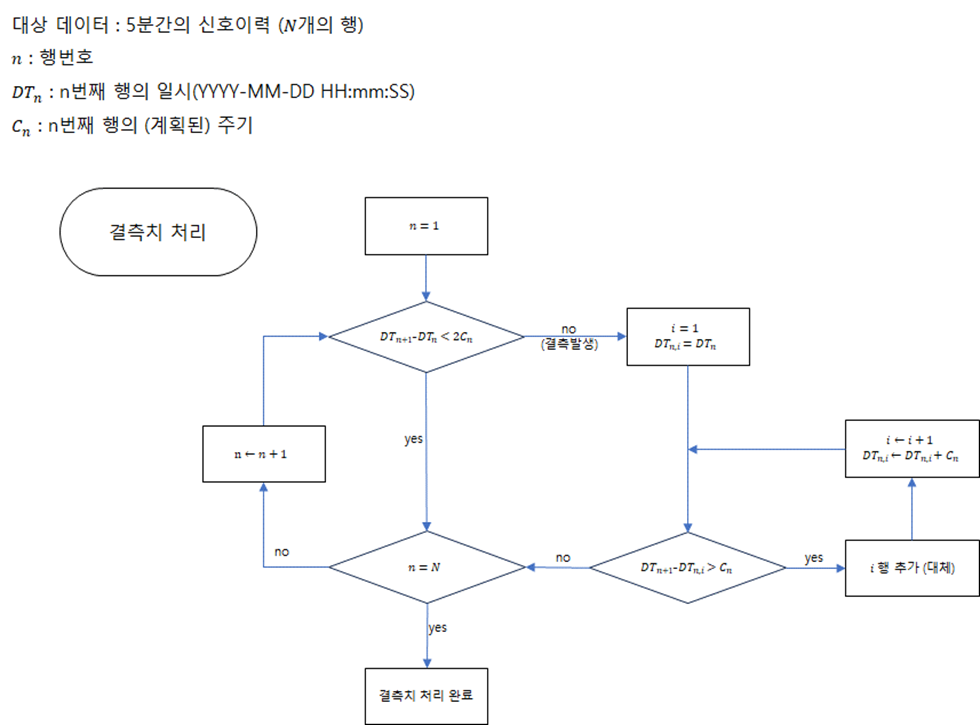

In [14]:
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
m = 60 # ranges from 0 to 287, but 0 makes an error where 288 = 86400//300
present_time = fmins[m] # 현재시점
# - 5분마다 신호이력 데이터 수집해서 통합테이블 생성할때
# 1. 조회시점의 유닉스 타임을 기준으로 신호이력의 유닉스 타임이 1시간 이내인 데이터 수집
rhistory = history.copy() # recent history 1704393231
rhistory = rhistory[(rhistory.end_unix < present_time) & (rhistory.end_unix >= present_time - 3600)]
rhist = rhistory.copy()[rhistory.inter_no == 175]
rhist_diff = rhist.copy()
rhist_diff['diff'] = rhist_diff['end_unix'].diff().fillna(0).astype(int)
display(rhist_diff)
rhist = rhist.reset_index(drop=True)
new_rows = []
for n in range(len(rhist) - 1):
    curr_unix = rhist.iloc[n].end_unix # current end_unix
    next_unix = rhist.iloc[n+1].end_unix # next end_unix
    cycle = rhist.iloc[n].cycle
    start_seconds = np.array(timetable.start_seconds)
    idx = (start_seconds <= curr_unix).sum() - 1
    start_hour = timetable.iloc[idx].start_hour
    start_minute = timetable.iloc[idx].start_minute
    # 1-1. 결측치 처리 : 인접한 두 end_unix의 차이가 계획된 주기의 두 배보다 크거나 같으면 결측이 일어났다고 판단
    if next_unix - curr_unix >= 2 * cycle:
        # 현재 unix를 계획된 주기만큼 늘려가면서 한 행씩 대체해나간다.
        #(다음 unix와의 차이가 계획된 주기보다 작거나 같아질 때까지)
        while next_unix - curr_unix > cycle:
            curr_unix += cycle
            # print(curr_unix)
            prow = pland[(pland.inter_no==175) & (pland.start_hour==start_hour) & (pland.start_minute==start_minute)] # planned row
            prow = prow.drop(['start_hour', 'start_minute'], axis=1)
            prow['end_unix'] = curr_unix
            display(prow)
            new_rows.append(prow)
    # print(next_unix - curr_unix < 2 * cycle, next_unix - curr_unix)
rhist = pd.concat([rhist] + new_rows).sort_values(['end_unix'])
rhist_diff = rhist.copy()
rhist_diff['diff'] = rhist_diff['end_unix'].diff().fillna(0).astype(int)
display(rhist_diff)

inter_no    end_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
924        175  1704394830      37      39      25      30      29       0   
933        175  1704394990      37      39      25      30      29       0   
942        175  1704395150      37      39      25      30      29       0   
953        175  1704395310      37      39      25      30      29       0   
962        175  1704395470      37      39      25      30      29       0   
971        175  1704395630      37      39      25      30      29       0   
982        175  1704395790      37      39      25      30      29       0   
993        175  1704395950      37      39      25      30      29       0   
1002       175  1704396111      37      39      25      30      29       0   
1014       175  1704396270      37      39      25      30      29       0   
1023       175  1704396430      37      39      25      30      29       0   
1033       175  1704396589      37      39      25      30      29       0   
1046       175  1704396750      37      39      25      30      29       0   
1055       175  1704396909      37      39      25      30      29       0   
1082       175  1704397343      37      39      25      30      29       0   
1093       175  1704397500      37      39      25      30      29       0   
1102       175  1704397660      37      39      25      30      29       0   
1114       175  1704397820      37      39      25      30      29       0   
1124       175  1704397980      37      39      25      30      29       0   
1133       175  1704398140      37      39      25      30      29       0   
1146       175  1704398300      37      39      25      30      29       0   

      ddur_7  ddur_8  cycle  offset  diff  
924        0       0    160      57     0  
933        0       0    160      57   160  
942        0       0    160      57   160  
953        0       0    160      57   160  
962        0       0    160      57   160  
971        0       0    160      57   160  
982        0       0    160      57   160  
993        0       0    160      57   160  
1002       0       0    160      57   161  
1014       0       0    160      57   159  
1023       0       0    160      57   160  
1033       0       0    160      57   159  
1046       0       0    160      57   161  
1055       0       0    160      57   159  
1082       0       0    160      57   434  
1093       0       0    160      57   157  
1102       0       0    160      57   160  
1114       0       0    160      57   160  
1124       0       0    160      57   160  
1133       0       0    160      57   160  
1146       0       0    160      57   160

inter_no  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  ddur_7  ddur_8  \
0       175      37      39      25      30      29       0       0       0   

   cycle  offset    end_unix  
0    160      57  1704397069

inter_no  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  ddur_7  ddur_8  \
0       175      37      39      25      30      29       0       0       0   

   cycle  offset    end_unix  
0    160      57  1704397229

inter_no    end_unix  ddur_1  ddur_2  ddur_3  ddur_4  ddur_5  ddur_6  \
0        175  1704394830      37      39      25      30      29       0   
1        175  1704394990      37      39      25      30      29       0   
2        175  1704395150      37      39      25      30      29       0   
3        175  1704395310      37      39      25      30      29       0   
4        175  1704395470      37      39      25      30      29       0   
5        175  1704395630      37      39      25      30      29       0   
6        175  1704395790      37      39      25      30      29       0   
7        175  1704395950      37      39      25      30      29       0   
8        175  1704396111      37      39      25      30      29       0   
9        175  1704396270      37      39      25      30      29       0   
10       175  1704396430      37      39      25      30      29       0   
11       175  1704396589      37      39      25      30      29       0   
12       175  1704396750      37      39      25      30      29       0   
13       175  1704396909      37      39      25      30      29       0   
0        175  1704397069      37      39      25      30      29       0   
0        175  1704397229      37      39      25      30      29       0   
14       175  1704397343      37      39      25      30      29       0   
15       175  1704397500      37      39      25      30      29       0   
16       175  1704397660      37      39      25      30      29       0   
17       175  1704397820      37      39      25      30      29       0   
18       175  1704397980      37      39      25      30      29       0   
19       175  1704398140      37      39      25      30      29       0   
20       175  1704398300      37      39      25      30      29       0   

    ddur_7  ddur_8  cycle  offset  diff  
0        0       0    160      57     0  
1        0       0    160      57   160  
2        0       0    160      57   160  
3        0       0    160      57   160  
4        0       0    160      57   160  
5        0       0    160      57   160  
6        0       0    160      57   160  
7        0       0    160      57   160  
8        0       0    160      57   161  
9        0       0    160      57   159  
10       0       0    160      57   160  
11       0       0    160      57   159  
12       0       0    160      57   161  
13       0       0    160      57   159  
0        0       0    160      57   160  
0        0       0    160      57   160  
14       0       0    160      57   114  
15       0       0    160      57   157  
16       0       0    160      57   160  
17       0       0    160      57   160  
18       0       0    160      57   160  
19       0       0    160      57   160  
20       0       0    160      57   160

In [18]:
print(rhist.end_unix.max())
print(present_time)

1704398300
1704398400
